In [1]:
DATASET_data="rec.mu2e.CRV_wideband_cosmics.CRVWB-000-008-000.root"
DATASET_MC_0012_v1="nts.mu2e.CRV_wideband_cosmics-mc.config_0012_v1.root"
DATASET_MC_0012_v2="nts.mu2e.CRV_wideband_cosmics-mc.config_0012_v2.root"

DATASET_MC_v17="nts.mu2e.WidebandCRV_v17.MDC2020ai.root"
DATASET_MC_v17a="nts.mu2e.WidebandCRV_v17a.MDC2020ai.root"
DATASET_MC_v17b="nts.mu2e.WidebandCRV_v17b.MDC2020ai.root"
DATASET_MC_v19="nts.mu2e.WidebandCRV_v19.MDC2020aj.root"

In [6]:
import time
import os
import numpy as np
import gc
from mu2etools import *
from mu2etools import wideband
import hist
from hist import Hist
from scipy import stats

hep.style.use('ATLAS')

In [3]:
runs = [1720, 1721, 1722, 1723, 1724, 1727, 1728, 1729, 1730, 1731, 1732, 1738, 2004, 2005, 2006, 2007, 2008, 2009, 2015, 2024, 2025, 2026, 2027, 2028]
processor = wideband.DataProcessor(treename='run', runlist=runs, userunlist=True, remove=False)
filelist = processor.getFilelist(DATASET_data, root_schema=True)
filelist = ["{}{}".format(i, ":run") for i in filelist]
PEs = 'PEsTemperatureCorrected'

# List of variable to import
varlist=[PEs, 'trackIntercept', 'trackChi2', 'trackPoints', 'trackPEs', 'trackSlope',
         'runNumber', 'subrunNumber', 'spillNumber', 'eventNumber']
varlist_keep = ['PEs_testlayers', 'runNumber', 'subrunNumber', 'spillNumber', 'eventNumber', 'trackSlope']

ar_skim_list_data = []

allevents = 0
cutevents = 0

allfiles = 0
filesloaded = 0

for idx, filename in enumerate(filelist):
    if idx%100 == 0:
        print("Processing file: %s"%filename)
    try:
        allfiles += 1
        with uproot.open(filename) as file:
            for ar in file.iterate(step_size="10MB", 
                                           filter_name=varlist, 
                                           report=False, library='ak'):
                allevents += len(ar["eventNumber"])    

                ar = ar[(ak.mean(ar[PEs][:,0,0:32], axis=-1)>=0) &
                        (ak.mean(ar[PEs][:,0,32:64], axis=-1)>=0) &
                        (ak.mean(ar[PEs][:,1,0:32], axis=-1)>=0) &
                        (ak.mean(ar[PEs][:,1,32:64], axis=-1)>=0) &
                        (ak.mean(ar[PEs][:,2,0:32], axis=-1)>=0) &
                        (ak.mean(ar[PEs][:,2,32:64], axis=-1)>=0) &
                        (ak.mean(ar[PEs][:,3,0:32], axis=-1)>=0) &
                        (ak.mean(ar[PEs][:,3,32:64], axis=-1)>=0) &
                        (ak.mean(ar[PEs][:,4,0:32], axis=-1)>=0) &
                        (ak.mean(ar[PEs][:,4,32:64], axis=-1)>=0) &
                        (ak.mean(ar[PEs][:,5,0:32], axis=-1)>=0) &
                        (ak.mean(ar[PEs][:,5,32:64], axis=-1)>=0) &
                        (ak.mean(ar[PEs][:,6,0:32], axis=-1)>=0) &
                        (ak.mean(ar[PEs][:,6,32:64], axis=-1)>=0) &
                        (ak.mean(ar[PEs][:,7,0:32], axis=-1)>=0) &
                        (ak.mean(ar[PEs][:,7,32:64], axis=-1)>=0)]   

                ar[PEs] = ak.where(ar[PEs] >= 5, ar[PEs], 0)
                
                FEB0_0 = (ak.sum(ar[PEs][:,0,8:28], axis=-1)>10)
                FEB0_1 = (ak.sum(ar[PEs][:,0,36:60], axis=-1)>10)

                FEB1_0 = (ak.sum(ar[PEs][:,1,4:28], axis=-1)>10) #0:32
                FEB1_1 = (ak.sum(ar[PEs][:,1,36:60], axis=-1)>10)

                FEB2_0 = (ak.sum(ar[PEs][:,2,4:28], axis=-1)>10)
                FEB2_1 = (ak.sum(ar[PEs][:,2,36:60], axis=-1)>10) #32:64

                FEB3_0 = (ak.sum(ar[PEs][:,3,8:28], axis=-1)>10)
                FEB3_1 = (ak.sum(ar[PEs][:,3,36:60], axis=-1)>10)

                FEB4_0 = (ak.sum(ar[PEs][:,4,4:28], axis=-1)>10)
                FEB4_1 = (ak.sum(ar[PEs][:,4,36:60], axis=-1)>10)

                FEB5_0 = (ak.sum(ar[PEs][:,5,4:28], axis=-1)>10)
                FEB5_1 = (ak.sum(ar[PEs][:,5,36:60], axis=-1)>10)

                FEB6_0 = (ak.sum(ar[PEs][:,6,4:28], axis=-1)>10)
                FEB6_1 = (ak.sum(ar[PEs][:,6,36:60], axis=-1)>10)

                FEB7_0 = (ak.sum(ar[PEs][:,7,4:28], axis=-1)>10)
                FEB7_1 = (ak.sum(ar[PEs][:,7,36:60], axis=-1)>10)

                nTrigHits = ak.values_astype(FEB0_0, "int") + ak.values_astype(FEB0_1, "int") + \
                            ak.values_astype(FEB3_0, "int") + ak.values_astype(FEB3_1, "int") + \
                            ak.values_astype(FEB4_0, "int") + ak.values_astype(FEB4_1, "int") + \
                            ak.values_astype(FEB5_0, "int") + ak.values_astype(FEB5_1, "int") + \
                            ak.values_astype(FEB6_0, "int") + ak.values_astype(FEB6_1, "int") + \
                            ak.values_astype(FEB7_0, "int") + ak.values_astype(FEB7_1, "int")

                ar['trackChi2NDF'] = ak.where(ar['trackPoints'] > 2, ar['trackChi2'] / (ar['trackPoints'] - 2), -999)
                
                ar["PEs_testlayers"] = ar[PEs][:,np.arange(1,3)]

                ar_cleanup = ar[(nTrigHits >=12) &
                                (ar["trackIntercept"] < -200) & (ar["trackIntercept"] > -700) &
                                (ar["trackPEs"] < 3000) & 
                                (ar["trackPoints"] < 40) &
                                (ar["trackChi2NDF"] < 30) & (ar["trackChi2NDF"] > 0)]

                ar_skim_list_data.append(ar_cleanup[varlist_keep])
                cutevents += len(ar_cleanup["eventNumber"])

                filesloaded += 1
    except:
        continue


print("{0} files loaded out of {1}".format(filesloaded, allfiles))
print("Total events: {0}".format(allevents))
print("Events after cuts: {0}".format(cutevents))

Processing file: root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-rec/rec/mu2e/CRV_wideband_cosmics/CRVWB-000-008-000/root/fc/22/rec.mu2e.CRV_wideband_cosmics.CRVWB-000-008-000.001720_000.root:run


/home/thoroho/.conda/envs/Mu2eCRV/lib/python3.10/site-packages/awkward/_backends.py:57: RuntimeWarning: divide by zero encountered in divide
  return getattr(ufunc, method)(*args, **kwargs)
/home/thoroho/.conda/envs/Mu2eCRV/lib/python3.10/site-packages/awkward/_backends.py:57: RuntimeWarning: invalid value encountered in divide
  return getattr(ufunc, method)(*args, **kwargs)


499 files loaded out of 75
Total events: 9917974
Events after cuts: 2218186


In [5]:
thresh = np.linspace(10, 130, 25, endpoint=True)
pass_1_data = np.zeros_like(thresh)
pass_2_data = np.zeros_like(thresh)
pass_3_data = np.zeros_like(thresh)
pass_4_data = np.zeros_like(thresh)
pass_3of4_data = np.zeros_like(thresh)
nTrig_data = np.zeros_like(thresh)

for i in range(len(ar_skim_list_data)):
    ar_clean = ar_skim_list_data[i]

    for j in range(len(thresh)):
        ## testing module layers ##
        FEB1_0 = (ak.sum(ar_clean["PEs_testlayers"][:,0,0:32], axis=-1)>thresh[j])
        FEB1_1 = (ak.sum(ar_clean["PEs_testlayers"][:,0,32:64], axis=-1)>thresh[j])
        FEB2_0 = (ak.sum(ar_clean["PEs_testlayers"][:,1,0:32], axis=-1)>thresh[j])
        FEB2_1 = (ak.sum(ar_clean["PEs_testlayers"][:,1,32:64], axis=-1)>thresh[j])

        nHits_test = ak.values_astype(FEB1_0, "int") + ak.values_astype(FEB1_1, "int") + \
                     ak.values_astype(FEB2_0, "int") + ak.values_astype(FEB2_1, "int")

        pass_1_data[j] += ak.count(ar_clean[FEB1_0]["eventNumber"])
        pass_2_data[j] += ak.count(ar_clean[FEB1_1]["eventNumber"])
        pass_3_data[j] += ak.count(ar_clean[FEB2_0]["eventNumber"])
        pass_4_data[j] += ak.count(ar_clean[FEB2_1]["eventNumber"])
        pass_3of4_data[j] += ak.count(ar_clean[(nHits_test >= 3)]["eventNumber"])
        nTrig_data[j] += ak.count(ar_clean["eventNumber"])

In [12]:
print(pass_3of4_data)
print(nTrig_data)

[2218177. 2218176. 2218176. 2218176. 2218176. 2218176. 2218176. 2218175.
 2218175. 2218162. 2218105. 2217786. 2216371. 2211232. 2195506. 2152873.
 2055128. 1872083. 1596756. 1264705.  934840.  657157.  451697.  312165.
  222010.]
[2218186. 2218186. 2218186. 2218186. 2218186. 2218186. 2218186. 2218186.
 2218186. 2218186. 2218186. 2218186. 2218186. 2218186. 2218186. 2218186.
 2218186. 2218186. 2218186. 2218186. 2218186. 2218186. 2218186. 2218186.
 2218186.]


In [38]:
ineff_layer0_data = np.zeros_like(thresh)
ineff_layer1_data = np.zeros_like(thresh)
ineff_layer2_data = np.zeros_like(thresh)
ineff_layer3_data = np.zeros_like(thresh)

ineff_extrapolated_data = np.zeros_like(thresh)

for i in range(len(thresh)):
    ineff_0 = 1 - pass_1_data[i]/nTrig_data[i]
    ineff_1 = 1 - pass_2_data[i]/nTrig_data[i]
    ineff_2 = 1 - pass_3_data[i]/nTrig_data[i]
    ineff_3 = 1 - pass_4_data[i]/nTrig_data[i]

    eff_avg = (pass_1_data[i]/nTrig_data[i] + pass_2_data[i]/nTrig_data[i] + \
               pass_3_data[i]/nTrig_data[i] + pass_4_data[i]/nTrig_data[i])/4

    eff_3of4 = 4*eff_avg**3 - 3*eff_avg**4

    ineff_layer0_data[i] = ineff_0
    ineff_layer1_data[i] = ineff_1
    ineff_layer2_data[i] = ineff_2
    ineff_layer3_data[i] = ineff_3
    ineff_extrapolated_data[i] = 1 - eff_3of4
    
ineff_3of4_data = np.ones_like(thresh) - np.divide(pass_3of4_data, nTrig_data)
error_3of4_data = np.zeros((2, len(thresh)))
for i in range(len(thresh)):
    result = stats.binomtest(int(pass_3of4_data[i]), int(nTrig_data[i]), 0.5)
    error_3of4_data[1][i] = (1 - result.proportion_ci(0.68).low) - ineff_3of4_data[i]
    error_3of4_data[0][i] = ineff_3of4_data[i] - (1 - result.proportion_ci(0.68).high)
    #error_3of4_data[i] = np.sqrt(ineff_3of4[i]*(1-ineff_3of4[i])/nTrig[i])

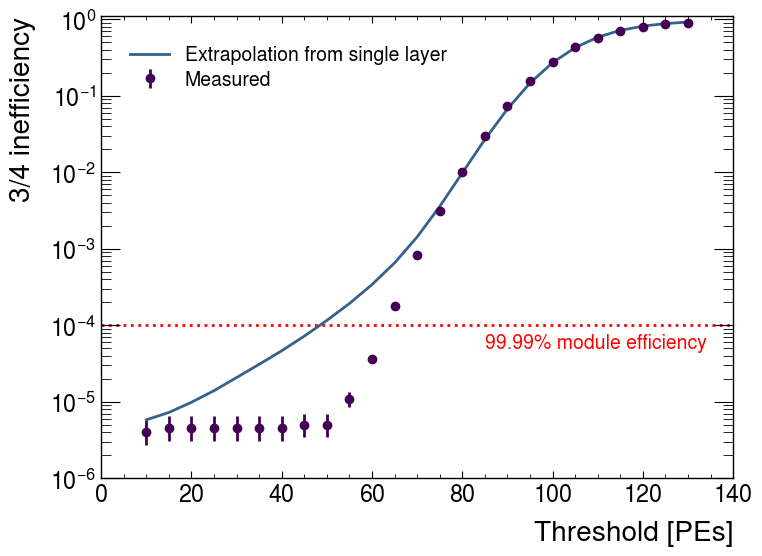

In [39]:
#plt.rcParams['figure.dpi']=900

#fig, ax = plt.subplots()

#ax.errorbar(np.linspace(10, 130, 25, endpoint=True), ineff_layer0_data, yerr=error_layer0_data, fmt='o', color='#FDE725FF', label="Layer 1", markersize=6)
#ax.errorbar(np.linspace(10, 130, 25, endpoint=True), ineff_layer1_data, yerr=error_layer1_data, fmt='v', color='#3CBB75FF', label="Layer 2", markersize=6)
#ax.errorbar(np.linspace(10, 130, 25, endpoint=True), ineff_layer2_data, yerr=error_layer2_data, fmt='s', color='#33638DFF', label="Layer 3", markersize=6)
#ax.errorbar(np.linspace(10, 130, 25, endpoint=True), ineff_layer3_data, yerr=error_layer3_data, fmt='^', color='#440154FF', label="Layer 4", markersize=6)

#plt.legend()
#ax.set_ylim(0.0006, 1.1)
#ax.set_yscale('log')

#ax.set_xlabel('Threshold [PEs]')
#ax.set_ylabel('Single layer inefficiency')

#plt.show()


fig, ax = plt.subplots()

ax.errorbar(np.linspace(10, 130, 25, endpoint=True), ineff_3of4_data, yerr=error_3of4_data, fmt='o', color='#440154FF', label='Measured', markersize=6)
ax.plot(np.linspace(10, 130, 25, endpoint=True), ineff_extrapolated_data, '-', color='#33638DFF', label='Extrapolation from single layer')

plt.axhline(y=0.0001, c='r', linestyle='dotted')
plt.text(85, 0.00005, '99.99% module efficiency', c='r') 

plt.legend()

ax.set_ylim(0.000001, 1.1)

ax.set_yscale('log')

ax.set_xlabel('Threshold [PEs]')
ax.set_ylabel('3/4 inefficiency')

plt.show()

In [54]:
processor = wideband.DataProcessor(treename='CrvWidebandTest/run', runlist=[1738], userunlist=False, remove=False)
filelist = processor.getFilelist(DATASET_MC_v17b, root_schema=True)
filelist = ["{}{}".format(i, ":CrvWidebandTest/run") for i in filelist]
PEs = 'PEs'

# List of variable to import
varlist=[PEs, 'trackIntercept', 'trackChi2', 'trackPoints', 'trackPEs', 
         'runNumber', 'subrunNumber', 'spillNumber', 'eventNumber']
varlist_keep = ['PEs_testlayers', 'runNumber', 'subrunNumber', 'spillNumber', 'eventNumber']

varlist.append('coincidencePosX')
varlist.append('coincidencePDGid')

ar_skim_list_MC = []

allevents = 0
cutevents = 0

allfiles = 0
filesloaded = 0

for idx, filename in enumerate(filelist):
    if idx%100 == 0:
        print("Processing file: %s"%filename)
    try:
        allfiles += 1
        with uproot.open(filename) as file:
            for ar in file.iterate(step_size="10MB", 
                                           filter_name=varlist, 
                                           report=False, library='ak'):
                allevents += len(ar["eventNumber"])

                ar = ar[(abs(ar["coincidencePosX"][:,1]+5604) < 50) & (abs(ar["coincidencePosX"][:,4] + 5604) < 50)]

                ar = ar[(ak.mean(ar[PEs][:,0,0:32], axis=-1)>=0) &
                        (ak.mean(ar[PEs][:,0,32:64], axis=-1)>=0) &
                        (ak.mean(ar[PEs][:,1,0:32], axis=-1)>=0) &
                        (ak.mean(ar[PEs][:,1,32:64], axis=-1)>=0) &
                        (ak.mean(ar[PEs][:,2,0:32], axis=-1)>=0) &
                        (ak.mean(ar[PEs][:,2,32:64], axis=-1)>=0) &
                        (ak.mean(ar[PEs][:,3,0:32], axis=-1)>=0) &
                        (ak.mean(ar[PEs][:,3,32:64], axis=-1)>=0) &
                        (ak.mean(ar[PEs][:,4,0:32], axis=-1)>=0) &
                        (ak.mean(ar[PEs][:,4,32:64], axis=-1)>=0) &
                        (ak.mean(ar[PEs][:,5,0:32], axis=-1)>=0) &
                        (ak.mean(ar[PEs][:,5,32:64], axis=-1)>=0) &
                        (ak.mean(ar[PEs][:,6,0:32], axis=-1)>=0) &
                        (ak.mean(ar[PEs][:,6,32:64], axis=-1)>=0) &
                        (ak.mean(ar[PEs][:,7,0:32], axis=-1)>=0) &
                        (ak.mean(ar[PEs][:,7,32:64], axis=-1)>=0)]                           
    
                ar[PEs] = ak.where(ar[PEs] >= 5, ar[PEs], 0)

                FEB0_0 = (ak.sum(ar[PEs][:,0,8:28], axis=-1)>10)
                FEB0_1 = (ak.sum(ar[PEs][:,0,36:60], axis=-1)>10)

                FEB1_0 = (ak.sum(ar[PEs][:,1,4:28], axis=-1)>10) #0:32
                FEB1_1 = (ak.sum(ar[PEs][:,1,36:60], axis=-1)>10)

                FEB2_0 = (ak.sum(ar[PEs][:,2,4:28], axis=-1)>10)
                FEB2_1 = (ak.sum(ar[PEs][:,2,36:60], axis=-1)>10) #32:64

                FEB3_0 = (ak.sum(ar[PEs][:,3,8:28], axis=-1)>10)
                FEB3_1 = (ak.sum(ar[PEs][:,3,36:60], axis=-1)>10)

                FEB4_0 = (ak.sum(ar[PEs][:,4,4:28], axis=-1)>10)
                FEB4_1 = (ak.sum(ar[PEs][:,4,36:60], axis=-1)>10)

                FEB5_0 = (ak.sum(ar[PEs][:,5,4:28], axis=-1)>10)
                FEB5_1 = (ak.sum(ar[PEs][:,5,36:60], axis=-1)>10)

                FEB6_0 = (ak.sum(ar[PEs][:,6,4:28], axis=-1)>10)
                FEB6_1 = (ak.sum(ar[PEs][:,6,36:60], axis=-1)>10)

                FEB7_0 = (ak.sum(ar[PEs][:,7,4:28], axis=-1)>10)
                FEB7_1 = (ak.sum(ar[PEs][:,7,36:60], axis=-1)>10)

                nTrigHits = ak.values_astype(FEB0_0, "int") + ak.values_astype(FEB0_1, "int") + \
                            ak.values_astype(FEB3_0, "int") + ak.values_astype(FEB3_1, "int") + \
                            ak.values_astype(FEB4_0, "int") + ak.values_astype(FEB4_1, "int") + \
                            ak.values_astype(FEB5_0, "int") + ak.values_astype(FEB5_1, "int") + \
                            ak.values_astype(FEB6_0, "int") + ak.values_astype(FEB6_1, "int") + \
                            ak.values_astype(FEB7_0, "int") + ak.values_astype(FEB7_1, "int")

                ar['trackIntercept'] = ar['trackIntercept'][:,0] - 39950.0

                ar['trackChi2NDF'] = ak.where(ar['trackPoints'][:,0] > 2, ar['trackChi2'][:,0] / (ar['trackPoints'][:,0] - 2), -999)
                ar['trackPEs'] = ar['trackPEs'][:,0]
                ar['trackPoints'] = ar['trackPoints'][:,0]

                ar["PEs_testlayers"] = ar[PEs][:,np.arange(1,3)]

                ar_cleanup = ar[(nTrigHits >=12) &
                                #(ar["trackIntercept"] < -200) & (ar["trackIntercept"] > -700) &
                                (ar["trackPEs"] < 3000) & 
                                (ar["trackPoints"] < 40) &
                                (ar["trackChi2NDF"] < 30) & (ar["trackChi2NDF"] > 0)]

                ar_skim_list_MC.append(ar_cleanup[varlist_keep])
                cutevents += len(ar_cleanup["eventNumber"])

                filesloaded += 1
        
    except:
        continue
    #if idx > 1:
    #    break


print("{0} files loaded out of {1}".format(filesloaded, allfiles))
print("Total events: {0}".format(allevents))
print("Events after cuts: {0}".format(cutevents))

Processing file: root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-nts/nts/mu2e/WidebandCRV_v17b/MDC2020ai/root/ee/b1/nts.mu2e.WidebandCRV_v17b.MDC2020ai.103001_00000000.root:CrvWidebandTest/run
Processing file: root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-nts/nts/mu2e/WidebandCRV_v17b/MDC2020ai/root/86/f8/nts.mu2e.WidebandCRV_v17b.MDC2020ai.103001_00000100.root:CrvWidebandTest/run
Processing file: root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-nts/nts/mu2e/WidebandCRV_v17b/MDC2020ai/root/d8/aa/nts.mu2e.WidebandCRV_v17b.MDC2020ai.103001_00000200.root:CrvWidebandTest/run
Processing file: root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-nts/nts/mu2e/WidebandCRV_v17b/MDC2020ai/root/08/e6/nts.mu2e.WidebandCRV_v17b.MDC2020ai.103001_00000300.root:CrvWidebandTest/run
Processing file: root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-nts/nts/mu2e/WidebandCRV_v17b/MDC2020ai/root/c2/33/nts.mu2e.WidebandCRV_v17b.MDC2020ai.103001_00000400.root:CrvWidebandTest/run
Processing file: root://fndcadoor.fnal.gov:1094/mu

In [55]:
thresh = np.linspace(10, 130, 25, endpoint=True)
pass_1_MC = np.zeros_like(thresh)
pass_2_MC = np.zeros_like(thresh)
pass_3_MC = np.zeros_like(thresh)
pass_4_MC = np.zeros_like(thresh)
pass_3of4_MC = np.zeros_like(thresh)
nTrig_MC = np.zeros_like(thresh)

for i in range(len(ar_skim_list_MC)):
    ar_clean = ar_skim_list_MC[i]

    for j in range(len(thresh)):
        ## testing module layers ##
        FEB1_0 = (ak.sum(ar_clean["PEs_testlayers"][:,0,0:32], axis=-1)>thresh[j])
        FEB1_1 = (ak.sum(ar_clean["PEs_testlayers"][:,0,32:64], axis=-1)>thresh[j])
        FEB2_0 = (ak.sum(ar_clean["PEs_testlayers"][:,1,0:32], axis=-1)>thresh[j])
        FEB2_1 = (ak.sum(ar_clean["PEs_testlayers"][:,1,32:64], axis=-1)>thresh[j])

        nHits_test = ak.values_astype(FEB1_0, "int") + ak.values_astype(FEB1_1, "int") + \
                     ak.values_astype(FEB2_0, "int") + ak.values_astype(FEB2_1, "int")

        pass_1_MC[j] += ak.count(ar_clean[FEB1_0]["eventNumber"])
        pass_2_MC[j] += ak.count(ar_clean[FEB1_1]["eventNumber"])
        pass_3_MC[j] += ak.count(ar_clean[FEB2_0]["eventNumber"])
        pass_4_MC[j] += ak.count(ar_clean[FEB2_1]["eventNumber"])
        pass_3of4_MC[j] += ak.count(ar_clean[(nHits_test >= 3)]["eventNumber"])
        nTrig_MC[j] += ak.count(ar_clean["eventNumber"])

In [56]:
ineff_layer0_MC = np.zeros_like(thresh)
ineff_layer1_MC = np.zeros_like(thresh)
ineff_layer2_MC = np.zeros_like(thresh)
ineff_layer3_MC = np.zeros_like(thresh)

ineff_extrapolated_MC = np.zeros_like(thresh)

for i in range(len(thresh)):
    ineff_0 = 1 - pass_1_MC[i]/nTrig_MC[i]
    ineff_1 = 1 - pass_2_MC[i]/nTrig_MC[i]
    ineff_2 = 1 - pass_3_MC[i]/nTrig_MC[i]
    ineff_3 = 1 - pass_4_MC[i]/nTrig_MC[i]

    eff_avg = (pass_1_MC[i]/nTrig_MC[i] + pass_2_MC[i]/nTrig_MC[i] + \
               pass_3_MC[i]/nTrig_MC[i] + pass_4_MC[i]/nTrig_MC[i])/4

    eff_3of4 = 4*eff_avg**3 - 3*eff_avg**4

    ineff_layer0_MC[i] = ineff_0
    ineff_layer1_MC[i] = ineff_1
    ineff_layer2_MC[i] = ineff_2
    ineff_layer3_MC[i] = ineff_3
    ineff_extrapolated_MC[i] = 1 - eff_3of4
    
ineff_3of4_MC = np.ones_like(thresh) - np.divide(pass_3of4_MC, nTrig_MC)
error_3of4_MC = np.zeros((2, len(thresh)))
for i in range(len(thresh)):
    result = stats.binomtest(int(pass_3of4_MC[i]), int(nTrig_MC[i]), 0.5)
    error_3of4_MC[1][i] = (1 - result.proportion_ci(0.68).low) - ineff_3of4_MC[i]
    error_3of4_MC[0][i] = ineff_3of4_MC[i] - (1 - result.proportion_ci(0.68).high)
    #error_3of4_data[i] = np.sqrt(ineff_3of4[i]*(1-ineff_3of4[i])/nTrig[i])

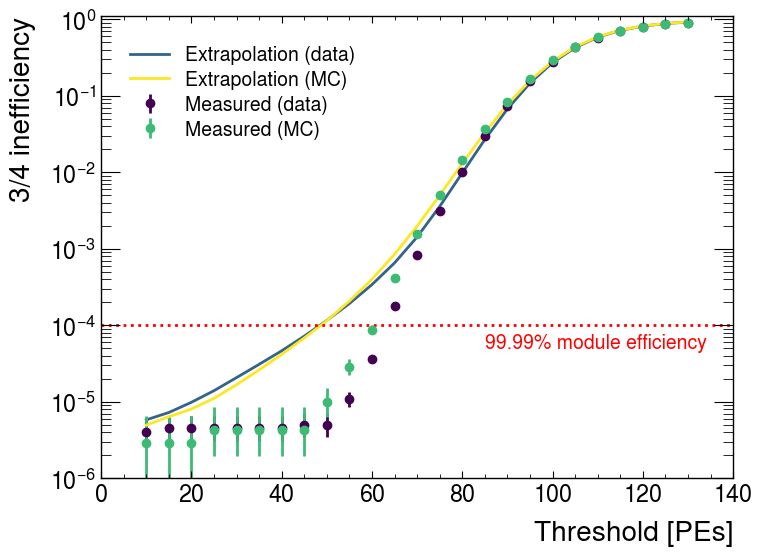

In [57]:
fig, ax = plt.subplots()

ax.errorbar(np.linspace(10, 130, 25, endpoint=True), ineff_3of4_data, yerr=error_3of4_data, fmt='o', color='#440154FF', label='Measured (data)', markersize=6)
ax.plot(np.linspace(10, 130, 25, endpoint=True), ineff_extrapolated_data, '-', color='#33638DFF', label='Extrapolation (data)')
ax.errorbar(np.linspace(10, 130, 25, endpoint=True), ineff_3of4_MC, yerr=error_3of4_MC, fmt='o', color='#3CBB75FF', label='Measured (MC)', markersize=6)
ax.plot(np.linspace(10, 130, 25, endpoint=True), ineff_extrapolated_MC, '-', color='#FDE725FF', label='Extrapolation (MC)')

plt.axhline(y=0.0001, c='r', linestyle='dotted')
plt.text(85, 0.00005, '99.99% module efficiency', c='r') 

plt.legend()

ax.set_ylim(0.000001, 1.1)

ax.set_yscale('log')

ax.set_xlabel('Threshold [PEs]')
ax.set_ylabel('3/4 inefficiency')

plt.show()

In [50]:
def GetLightYield(ar_skim_list):
    #h = Hist(hist.axis.Regular(bins=300, start=0, stop=300, name="light yield"))
    h = Hist(hist.axis.Regular(bins=60, start=0, stop=300, name="light yield", flow=False))
    for i in range(len(ar_skim_list)):
        ar_clean = ar_skim_list[i]
        
        h.fill(ak.sum(ar_clean["PEs_testlayers"][:,0,0:32], axis=-1))
        h.fill(ak.sum(ar_clean["PEs_testlayers"][:,0,32:64], axis=-1))
        h.fill(ak.sum(ar_clean["PEs_testlayers"][:,1,0:32], axis=-1))
        h.fill(ak.sum(ar_clean["PEs_testlayers"][:,1,32:64], axis=-1))
        
    return h

In [58]:
hMC = GetLightYield(ar_skim_list_MC)
hData = GetLightYield(ar_skim_list_data)

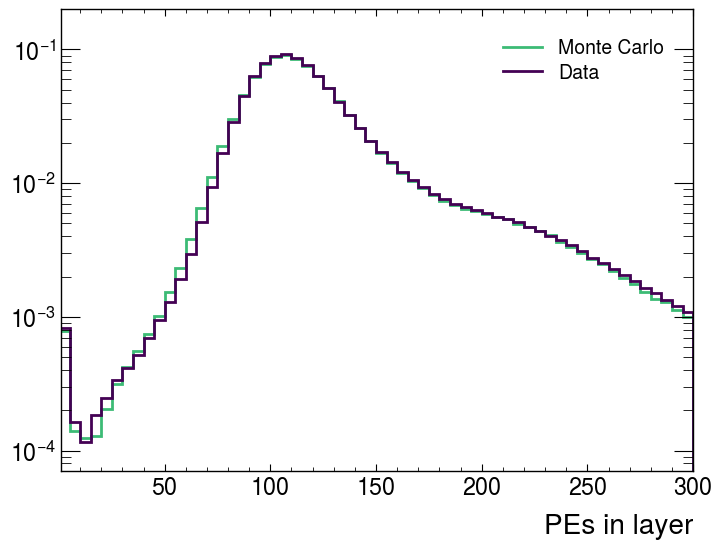

In [59]:
hMC_norm = hMC/hMC.sum()
hData_norm = hData/hData.sum()

fig, ax = plt.subplots()
hMC_norm.plot1d(label='Monte Carlo', color = '#3CBB75FF', linewidth=2.0)
hData_norm.plot1d(label='Data', color='#440154FF', linewidth=2.0)
ax.legend()
ax.set_xlabel('PEs in layer')
ax.set_yscale('log')
ax.set_xlim(1,300)
ax.set_ylim(7e-5, 0.2)
plt.show()

In [61]:
processor = wideband.DataProcessor(treename='CrvWidebandTest/run', runlist=[1738], userunlist=False, remove=False)
filelist = processor.getFilelist(DATASET_MC_v19, root_schema=True)
filelist = ["{}{}".format(i, ":CrvWidebandTest/run") for i in filelist]
PEs = 'PEs'

# List of variable to import
varlist=[PEs, 'trackIntercept', 'trackChi2', 'trackPoints', 'trackPEs', 
         'runNumber', 'subrunNumber', 'spillNumber', 'eventNumber']
varlist_keep = ['PEs_testlayers', 'runNumber', 'subrunNumber', 'spillNumber', 'eventNumber']

varlist.append('coincidencePDGid')

ar_skim_list_MC_v19 = []

allevents = 0
cutevents = 0

allfiles = 0
filesloaded = 0

for idx, filename in enumerate(filelist):
    if idx%100 == 0:
        print("Processing file: %s"%filename)
    try:
        allfiles += 1
        with uproot.open(filename) as file:
            for ar in file.iterate(step_size="10MB", 
                                           filter_name=varlist, 
                                           report=False, library='ak'):
                allevents += len(ar["eventNumber"])

                #remove this cut since we use trigger paddles
                #ar = ar[(abs(ar["coincidencePosX"][:,1]+5604) < 50) & (abs(ar["coincidencePosX"][:,4] + 5604) < 50)]

                ar = ar[(ak.mean(ar[PEs][:,0,0:32], axis=-1)>=0) &
                        (ak.mean(ar[PEs][:,0,32:64], axis=-1)>=0) &
                        (ak.mean(ar[PEs][:,1,0:32], axis=-1)>=0) &
                        (ak.mean(ar[PEs][:,1,32:64], axis=-1)>=0) &
                        (ak.mean(ar[PEs][:,2,0:32], axis=-1)>=0) &
                        (ak.mean(ar[PEs][:,2,32:64], axis=-1)>=0) &
                        (ak.mean(ar[PEs][:,3,0:32], axis=-1)>=0) &
                        (ak.mean(ar[PEs][:,3,32:64], axis=-1)>=0) &
                        (ak.mean(ar[PEs][:,4,0:32], axis=-1)>=0) &
                        (ak.mean(ar[PEs][:,4,32:64], axis=-1)>=0) &
                        (ak.mean(ar[PEs][:,5,0:32], axis=-1)>=0) &
                        (ak.mean(ar[PEs][:,5,32:64], axis=-1)>=0) &
                        (ak.mean(ar[PEs][:,6,0:32], axis=-1)>=0) &
                        (ak.mean(ar[PEs][:,6,32:64], axis=-1)>=0) &
                        (ak.mean(ar[PEs][:,7,0:32], axis=-1)>=0) &
                        (ak.mean(ar[PEs][:,7,32:64], axis=-1)>=0)]                           
    
                ar[PEs] = ak.where(ar[PEs] >= 5, ar[PEs], 0)

                FEB0_0 = (ak.sum(ar[PEs][:,0,8:28], axis=-1)>10)
                FEB0_1 = (ak.sum(ar[PEs][:,0,36:60], axis=-1)>10)

                FEB1_0 = (ak.sum(ar[PEs][:,1,4:28], axis=-1)>10) #0:32
                FEB1_1 = (ak.sum(ar[PEs][:,1,36:60], axis=-1)>10)

                FEB2_0 = (ak.sum(ar[PEs][:,2,4:28], axis=-1)>10)
                FEB2_1 = (ak.sum(ar[PEs][:,2,36:60], axis=-1)>10) #32:64

                FEB3_0 = (ak.sum(ar[PEs][:,3,8:28], axis=-1)>10)
                FEB3_1 = (ak.sum(ar[PEs][:,3,36:60], axis=-1)>10)

                FEB4_0 = (ak.sum(ar[PEs][:,4,4:28], axis=-1)>10)
                FEB4_1 = (ak.sum(ar[PEs][:,4,36:60], axis=-1)>10)

                FEB5_0 = (ak.sum(ar[PEs][:,5,4:28], axis=-1)>10)
                FEB5_1 = (ak.sum(ar[PEs][:,5,36:60], axis=-1)>10)

                FEB6_0 = (ak.sum(ar[PEs][:,6,4:28], axis=-1)>10)
                FEB6_1 = (ak.sum(ar[PEs][:,6,36:60], axis=-1)>10)

                FEB7_0 = (ak.sum(ar[PEs][:,7,4:28], axis=-1)>10)
                FEB7_1 = (ak.sum(ar[PEs][:,7,36:60], axis=-1)>10)

                nTrigHits = ak.values_astype(FEB0_0, "int") + ak.values_astype(FEB0_1, "int") + \
                            ak.values_astype(FEB3_0, "int") + ak.values_astype(FEB3_1, "int") + \
                            ak.values_astype(FEB4_0, "int") + ak.values_astype(FEB4_1, "int") + \
                            ak.values_astype(FEB5_0, "int") + ak.values_astype(FEB5_1, "int") + \
                            ak.values_astype(FEB6_0, "int") + ak.values_astype(FEB6_1, "int") + \
                            ak.values_astype(FEB7_0, "int") + ak.values_astype(FEB7_1, "int")

                ar['trackIntercept'] = ar['trackIntercept'][:,0] - 39950.0

                ar['trackChi2NDF'] = ak.where(ar['trackPoints'][:,0] > 2, ar['trackChi2'][:,0] / (ar['trackPoints'][:,0] - 2), -999)
                ar['trackPEs'] = ar['trackPEs'][:,0]
                ar['trackPoints'] = ar['trackPoints'][:,0]

                ar["PEs_testlayers"] = ar[PEs][:,np.arange(1,3)]

                ar_cleanup = ar[(nTrigHits >=12) &
                                #(ar["trackIntercept"] < -200) & (ar["trackIntercept"] > -700) &
                                (ar["trackPEs"] < 3000) & 
                                (ar["trackPoints"] < 40) &
                                (ar["trackChi2NDF"] < 30) & (ar["trackChi2NDF"] > 0)]

                ar_skim_list_MC_v19.append(ar_cleanup[varlist_keep])
                cutevents += len(ar_cleanup["eventNumber"])

                filesloaded += 1
        
    except:
        continue
    #if idx > 1:
    #    break


print("{0} files loaded out of {1}".format(filesloaded, allfiles))
print("Total events: {0}".format(allevents))
print("Events after cuts: {0}".format(cutevents))

Processing file: root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-nts/nts/mu2e/WidebandCRV_v19/MDC2020aj/root/26/5a/nts.mu2e.WidebandCRV_v19.MDC2020aj.103001_00000000.root:CrvWidebandTest/run
Processing file: root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-nts/nts/mu2e/WidebandCRV_v19/MDC2020aj/root/2f/91/nts.mu2e.WidebandCRV_v19.MDC2020aj.103001_00000105.root:CrvWidebandTest/run
Processing file: root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-nts/nts/mu2e/WidebandCRV_v19/MDC2020aj/root/48/7d/nts.mu2e.WidebandCRV_v19.MDC2020aj.103001_00000206.root:CrvWidebandTest/run
Processing file: root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-nts/nts/mu2e/WidebandCRV_v19/MDC2020aj/root/f9/43/nts.mu2e.WidebandCRV_v19.MDC2020aj.103001_00000309.root:CrvWidebandTest/run
Processing file: root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-nts/nts/mu2e/WidebandCRV_v19/MDC2020aj/root/80/d3/nts.mu2e.WidebandCRV_v19.MDC2020aj.103001_00000411.root:CrvWidebandTest/run


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


Processing file: root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-nts/nts/mu2e/WidebandCRV_v19/MDC2020aj/root/05/88/nts.mu2e.WidebandCRV_v19.MDC2020aj.103001_00000513.root:CrvWidebandTest/run
Processing file: root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-nts/nts/mu2e/WidebandCRV_v19/MDC2020aj/root/9d/82/nts.mu2e.WidebandCRV_v19.MDC2020aj.103001_00000620.root:CrvWidebandTest/run
Processing file: root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-nts/nts/mu2e/WidebandCRV_v19/MDC2020aj/root/52/af/nts.mu2e.WidebandCRV_v19.MDC2020aj.103001_00000725.root:CrvWidebandTest/run
Processing file: root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-nts/nts/mu2e/WidebandCRV_v19/MDC2020aj/root/fa/88/nts.mu2e.WidebandCRV_v19.MDC2020aj.103001_00000828.root:CrvWidebandTest/run
Processing file: root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-nts/nts/mu2e/WidebandCRV_v19/MDC2020aj/root/1c/a1/nts.mu2e.WidebandCRV_v19.MDC2020aj.103001_00000931.root:CrvWidebandTest/run
2758 files loaded out of 965
Total events: 46696928
Events a

In [62]:
thresh = np.linspace(10, 130, 25, endpoint=True)
pass_1_MC_v19 = np.zeros_like(thresh)
pass_2_MC_v19 = np.zeros_like(thresh)
pass_3_MC_v19 = np.zeros_like(thresh)
pass_4_MC_v19 = np.zeros_like(thresh)
pass_3of4_MC_v19 = np.zeros_like(thresh)
nTrig_MC_v19 = np.zeros_like(thresh)

for i in range(len(ar_skim_list_MC_v19)):
    ar_clean = ar_skim_list_MC_v19[i]

    for j in range(len(thresh)):
        ## testing module layers ##
        FEB1_0 = (ak.sum(ar_clean["PEs_testlayers"][:,0,0:32], axis=-1)>thresh[j])
        FEB1_1 = (ak.sum(ar_clean["PEs_testlayers"][:,0,32:64], axis=-1)>thresh[j])
        FEB2_0 = (ak.sum(ar_clean["PEs_testlayers"][:,1,0:32], axis=-1)>thresh[j])
        FEB2_1 = (ak.sum(ar_clean["PEs_testlayers"][:,1,32:64], axis=-1)>thresh[j])

        nHits_test = ak.values_astype(FEB1_0, "int") + ak.values_astype(FEB1_1, "int") + \
                     ak.values_astype(FEB2_0, "int") + ak.values_astype(FEB2_1, "int")

        pass_1_MC_v19[j] += ak.count(ar_clean[FEB1_0]["eventNumber"])
        pass_2_MC_v19[j] += ak.count(ar_clean[FEB1_1]["eventNumber"])
        pass_3_MC_v19[j] += ak.count(ar_clean[FEB2_0]["eventNumber"])
        pass_4_MC_v19[j] += ak.count(ar_clean[FEB2_1]["eventNumber"])
        pass_3of4_MC_v19[j] += ak.count(ar_clean[(nHits_test >= 3)]["eventNumber"])
        nTrig_MC_v19[j] += ak.count(ar_clean["eventNumber"])

In [63]:
ineff_layer0_MC_v19 = np.zeros_like(thresh)
ineff_layer1_MC_v19 = np.zeros_like(thresh)
ineff_layer2_MC_v19 = np.zeros_like(thresh)
ineff_layer3_MC_v19 = np.zeros_like(thresh)

ineff_extrapolated_MC_v19 = np.zeros_like(thresh)

for i in range(len(thresh)):
    ineff_0 = 1 - pass_1_MC_v19[i]/nTrig_MC_v19[i]
    ineff_1 = 1 - pass_2_MC_v19[i]/nTrig_MC_v19[i]
    ineff_2 = 1 - pass_3_MC_v19[i]/nTrig_MC_v19[i]
    ineff_3 = 1 - pass_4_MC_v19[i]/nTrig_MC_v19[i]

    eff_avg = (pass_1_MC_v19[i]/nTrig_MC_v19[i] + pass_2_MC_v19[i]/nTrig_MC_v19[i] + \
               pass_3_MC_v19[i]/nTrig_MC_v19[i] + pass_4_MC_v19[i]/nTrig_MC_v19[i])/4

    eff_3of4 = 4*eff_avg**3 - 3*eff_avg**4

    ineff_layer0_MC_v19[i] = ineff_0
    ineff_layer1_MC_v19[i] = ineff_1
    ineff_layer2_MC_v19[i] = ineff_2
    ineff_layer3_MC_v19[i] = ineff_3
    ineff_extrapolated_MC_v19[i] = 1 - eff_3of4
    
ineff_3of4_MC_v19 = np.ones_like(thresh) - np.divide(pass_3of4_MC_v19, nTrig_MC_v19)
error_3of4_MC_v19 = np.zeros((2, len(thresh)))
for i in range(len(thresh)):
    result = stats.binomtest(int(pass_3of4_MC_v19[i]), int(nTrig_MC_v19[i]), 0.5)
    error_3of4_MC_v19[1][i] = (1 - result.proportion_ci(0.68).low) - ineff_3of4_MC_v19[i]
    error_3of4_MC_v19[0][i] = ineff_3of4_MC_v19[i] - (1 - result.proportion_ci(0.68).high)
    #error_3of4_data[i] = np.sqrt(ineff_3of4[i]*(1-ineff_3of4[i])/nTrig[i])

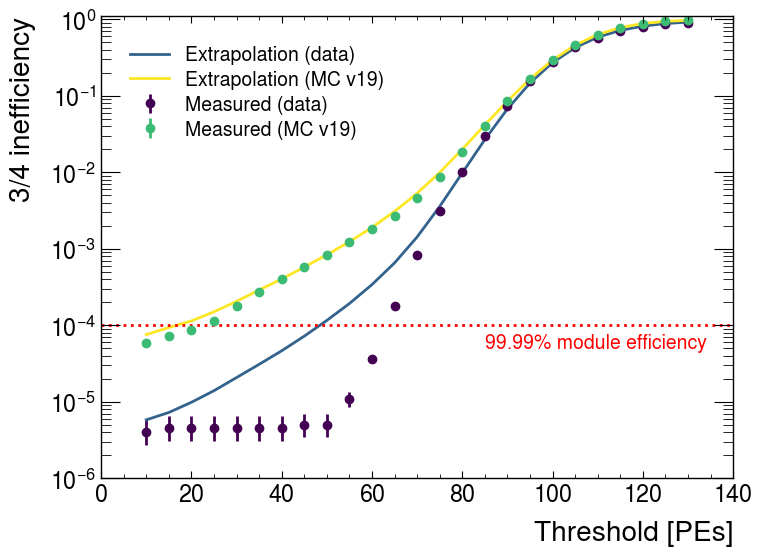

In [64]:
fig, ax = plt.subplots()

ax.errorbar(np.linspace(10, 130, 25, endpoint=True), ineff_3of4_data, yerr=error_3of4_data, fmt='o', color='#440154FF', label='Measured (data)', markersize=6)
ax.plot(np.linspace(10, 130, 25, endpoint=True), ineff_extrapolated_data, '-', color='#33638DFF', label='Extrapolation (data)')
ax.errorbar(np.linspace(10, 130, 25, endpoint=True), ineff_3of4_MC_v19, yerr=error_3of4_MC, fmt='o', color='#3CBB75FF', label='Measured (MC v19)', markersize=6)
ax.plot(np.linspace(10, 130, 25, endpoint=True), ineff_extrapolated_MC_v19, '-', color='#FDE725FF', label='Extrapolation (MC v19)')

plt.axhline(y=0.0001, c='r', linestyle='dotted')
plt.text(85, 0.00005, '99.99% module efficiency', c='r') 

plt.legend()

ax.set_ylim(0.000001, 1.1)

ax.set_yscale('log')

ax.set_xlabel('Threshold [PEs]')
ax.set_ylabel('3/4 inefficiency')

plt.show()